In [1]:
from typing import Union
import scanpy as sc
import anndata
import logging
import os
import numpy as np
import pandas as pd
import json
import sys
# import scanpy.external as sce
logging.basicConfig(level=logging.INFO)
import tqdm

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.neighbors import kneighbors_graph
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import KFold

from scipy import stats
import pingouin

import matplotlib.pyplot as plt
import seaborn as sns

import umap

# from PySpots.fish_helpers import *
from dredFISH.Analysis import basicu
from dredFISH.Analysis import regu
from dredFISH.Analysis import celltypeu
from dredFISH.Analysis import evalu
from dredFISH.Analysis import TissueGraph as tgh
from dredFISH.Analysis import powerplots

import importlib
importlib.reload(tgh)
importlib.reload(celltypeu)
importlib.reload(evalu)
importlib.reload(basicu)
sc.set_figure_params(figsize=(7, 7))

In [2]:
logging.info('hi')

INFO:root:hi


In [3]:
def anova_eta2(ydata, ylabels):
    """ydata = (nsample, nvariable)
    ylabel = (nsample,)
    """
    gmean = ydata.mean(axis=0)

    SSt = np.power((ydata-gmean), 2).sum(axis=0)
    SSb = np.zeros(ydata.shape[1])

    clsts = np.unique(ylabels)
    # Yclsts = []
    for clst in clsts:
        cond = ylabels==clst
        yclst = ydata[cond]
        lmean = yclst.mean(axis=0)
        ln = len(yclst)

        # for each gene
        SSb += np.power((lmean-gmean), 2)*ln

    # get eta2
    assert np.all(SSb<=SSt)
    eta2 = SSb/(SSt+1e-6)
    return eta2, SSt, SSb

# file paths and load data

In [4]:
prj_dir = '/bigstore/GeneralStorage/fangming/projects/dredfish/'
dat_dir = prj_dir + 'data/'
res_dir = prj_dir + 'data_dump/'
fig_dir = prj_dir + 'figures/'

# dredFISH data
dataset = 'DPNMF_PolyA_2021Nov19' # dataset tag
base_path = '/bigstore/Images2021/gaby/dredFISH/DPNMF_PolyA_2021Nov19/'
fish_path = f'{base_path}fishdata_2022Mar23/' # Zach's new version
# anndata_path = f'{base_path}results/raw_fishdata_Mar30.h5ad'
anndata_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/DPNMF_PolyA_2021Nov19_v2_results_anndata.h5ad'
# anndata_path = ''

# allen data
scrna_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/scrna_ss_ctxhippo_a_exon_DPNMF_matrix.h5ad'
# scrna_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/scrna_10x_ctxhippo_a_DPNMF_matrix.h5ad'

scrna_genes_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/scrna_ss_ctxhippo_a_exon_DPNMF_genes_matrix.h5ad'

# DPNMF matrix 
pmat_path = f'{dat_dir}dpnmf.csv' 

# allen tree
allen_tree_path='/bigstore/GeneralStorage/fangming/reference/allen_ccf/structures.json'

In [5]:
%%time

# load dredFISH
TMG = tgh.TissueMultiGraph(name=dataset)
# load raw counts data
if os.path.isfile(anndata_path):
    print('from AnnData')
    TMG.load_from_anndata(anndata_path)
else:
    print('from FishData')
    TMG.load_from_fishdata(fish_path, dataset, output_path=anndata_path)
# normalize (optional for spatial registration)
TMG.normalize_data(norm_cell=True, norm_bit=False)

### for now
data = TMG.data
# print(data)



# allen scrna matrix
ref_data = anndata.read_h5ad(scrna_path)
# print(ref_data)
ref_data_genes = anndata.read_h5ad(scrna_genes_path) # library size normed (no log)

# allen tree
allen_tree, allen_maps = regu.load_allen_tree(allen_tree_path)



from AnnData


INFO:root:113758 cells, minimum counts = 1248.0


CPU times: user 965 ms, sys: 1.46 s, total: 2.42 s
Wall time: 2.42 s


In [6]:
# select specific regions
selected_regions = ['Isocortex', 'HPF']
selected_all_sids = regu.expand_regions(allen_tree, selected_regions, 'acronym')

# selected cells
cond_cells = data.obs['region_id'].isin(selected_all_sids)
data = data[cond_cells]
data

View of AnnData object with n_obs × n_vars = 44075 × 24
    obs: 'label', 'pixel_x', 'pixel_y', 'nuclei_size', 'nuclei_signal', 'cytoplasm_size', 'cytoplasm_signal', 'total_size', 'total_signal', 'posname', 'posname_stage_x', 'posname_stage_y', 'cell_name', 'stage_x', 'stage_y', 'coord_x', 'coord_y', 'region_id', 'region_color', 'region_acronym'
    obsm: 'stage'
    layers: 'cytoplasm_vectors', 'nuclei_vectors', 'total_vectors', 'norm_cell'

In [7]:
pmat = pd.read_csv(pmat_path, index_col=0).loc[ref_data_genes.var.index]
pmatf = (pmat/pmat.sum(axis=0))
print(pmat.shape)
print(pmatf.shape)
pmat_maxw = pmat.max(axis=1)
pmatf_maxw = pmatf.max(axis=1)

(5576, 24)
(5576, 24)


In [8]:
# prepare
ref_data.obs = ref_data.obs.rename(columns={
    'class_label': 'Level_1_class_label', 
    'neighborhood_label': 'Level_2_neighborhood_label', 
    'subclass_label': 'Level_3_subclass_label', 
    # 'supertype_label', 
    'cluster_label': 'Level_5_cluster_label', 
})

celltype_levels = np.sort(ref_data.obs.filter(regex=r'^Level_[0-9]', axis=1).columns.values)
print(celltype_levels)

levels = celltype_levels[:3]      

X = np.array(data.layers['norm_cell'].copy())
X = basicu.zscore(X, axis=0)

Xref = np.array(ref_data.X.copy())
Xref = basicu.zscore(Xref, axis=0)

# y_refdata = ref_data.obs[levels].values
y = np.array(ref_data_genes.X.todense()).copy()
y = np.log10(y+1)

print(X.shape, Xref.shape, y.shape)

['Level_1_class_label' 'Level_2_neighborhood_label'
 'Level_3_subclass_label' 'Level_5_cluster_label']
(44075, 24) (73347, 24) (73347, 5576)


In [9]:
# ref_data.obs.groupby('Level_1_class_label').size()
print(ref_data)
print(ref_data_genes)

AnnData object with n_obs × n_vars = 73347 × 24
    obs: 'donor_sex_id', 'donor_sex_label', 'donor_sex_color', 'region_id', 'region_label', 'region_color', 'platform_label', 'cluster_order', 'Level_5_cluster_label', 'cluster_color', 'subclass_order', 'Level_3_subclass_label', 'subclass_color', 'neighborhood_id', 'Level_2_neighborhood_label', 'neighborhood_color', 'class_order', 'Level_1_class_label', 'class_color', 'exp_component_name', 'external_donor_name_label', 'full_genotype_label', 'facs_population_plan_label', 'injection_roi_label', 'injection_materials_label', 'injection_method_label', 'injection_type_label', 'full_genotype_id', 'full_genotype_color', 'external_donor_name_id', 'external_donor_name_color', 'facs_population_plan_id', 'facs_population_plan_color', 'injection_materials_id', 'injection_materials_color', 'injection_method_id', 'injection_method_color', 'injection_roi_id', 'injection_roi_color', 'injection_type_id', 'injection_type_color', 'cell_type_accession_label',

# Run gene reconstruction
- find neighbors using 24 bits
- reconstruct genes in high-dimensions based on those neighbors

- what gene set to use: 5818 genes involved (5576 overlap with scRNA SS)

# baseline gene reconstruction

In [10]:
def get_mse(y_true, y_pred):
    """
    """
    mse = np.power(y_true-y_pred, 2).mean()
    return mse

def get_r2(y_true, y_pred):
    """
    """
    # r2 = 1-(np.power(y_true-y_pred, 2).mean()/np.power(y_true-np.mean(y_true, axis=0), 2).mean())
    r2 = 1 - np.linalg.norm(y_true-y_pred)**2/np.linalg.norm(y_true-np.mean(y_true, axis=0))**2
    return r2

def get_r2_percol(y_true, y_pred, bias_in_pred=True):
    ycentered = y_true - np.mean(y_true, axis=0)
    if bias_in_pred:
        # y_pred count biases
        varexp = 1-(np.power(np.linalg.norm(y_true-y_pred, ord=2, axis=0), 2)/
                  np.power(np.linalg.norm(ycentered, ord=2, axis=0), 2)
                 )
    else:
        # y_pred doesn't count biases
        varexp = 1-(np.power(np.linalg.norm(ycentered-y_pred, ord=2, axis=0), 2)/
                  np.power(np.linalg.norm(ycentered, ord=2, axis=0), 2)
                 )
    return varexp

In [11]:
%%time

np.random.seed(0)
n_k = 30

model = NearestNeighbors(n_neighbors=n_k, metric='cosine') #, algorithm='ball_tree')
model.fit(Xref)

# test (row) by train (col)
knn = model.kneighbors_graph(X)
y_pred = knn.dot(y)/n_k
y_pred.shape

CPU times: user 3min 50s, sys: 56.9 s, total: 4min 47s
Wall time: 54.8 s


(44075, 5576)

In [12]:
genes = ref_data_genes.var.index.values
genes

array(['0610010F05Rik', '0610012G03Rik', '0610043K17Rik', ..., 'Zswim8',
       'Zyg11b', 'Zzef1'], dtype=object)

In [19]:
gene_ids = basicu.get_index_from_array(genes, ['Neurod6', 'Itpka', 'Slc32a1'])
gene_ids

array([3213, 2470, 4427])

0.0 649.4491439598543


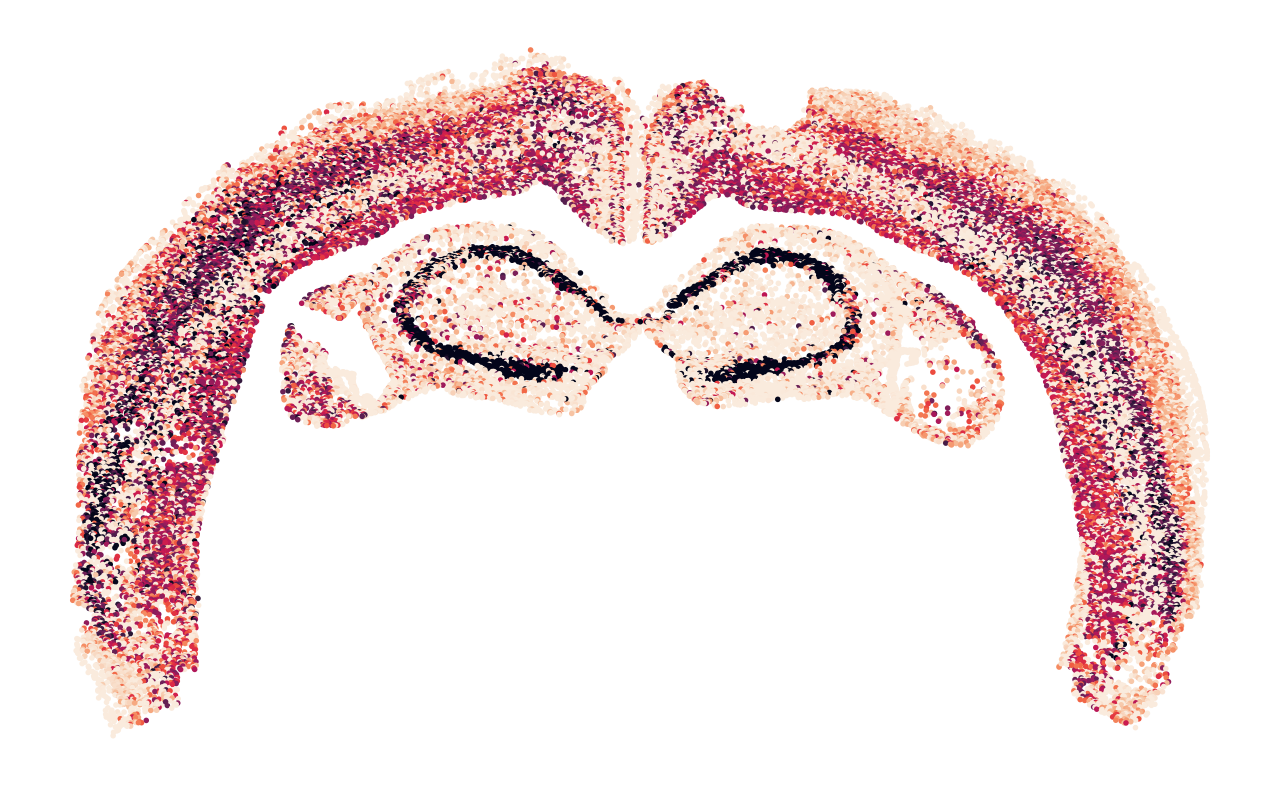

In [15]:
_x = data.obs['coord_x'].values
_y = data.obs['coord_y'].values

_c = np.power(10, y_pred[:,3213])-1
lo = np.percentile(_c, 0)
hi = np.percentile(_c, 95)
_c = np.clip(_c, lo, hi)
print(lo, hi)


fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(_x, _y, c=_c, s=1,
           rasterized=True,
           cmap='rocket_r',
          )
ax.axis('off')
ax.invert_yaxis()
ax.set_aspect('equal')
# powerplots.savefig_autodate(fig, os.path.join(fig_dir, 'spatial_level2_hippo.pdf'))
plt.show()

In [16]:
basicu.reset_logging(level=logging.WARNING)
logging.info('hi')

saved the figure to: /bigstore/GeneralStorage/fangming/projects/dredfish/figures/dredfish_gene_recon_eg_2022-05-12.pdf


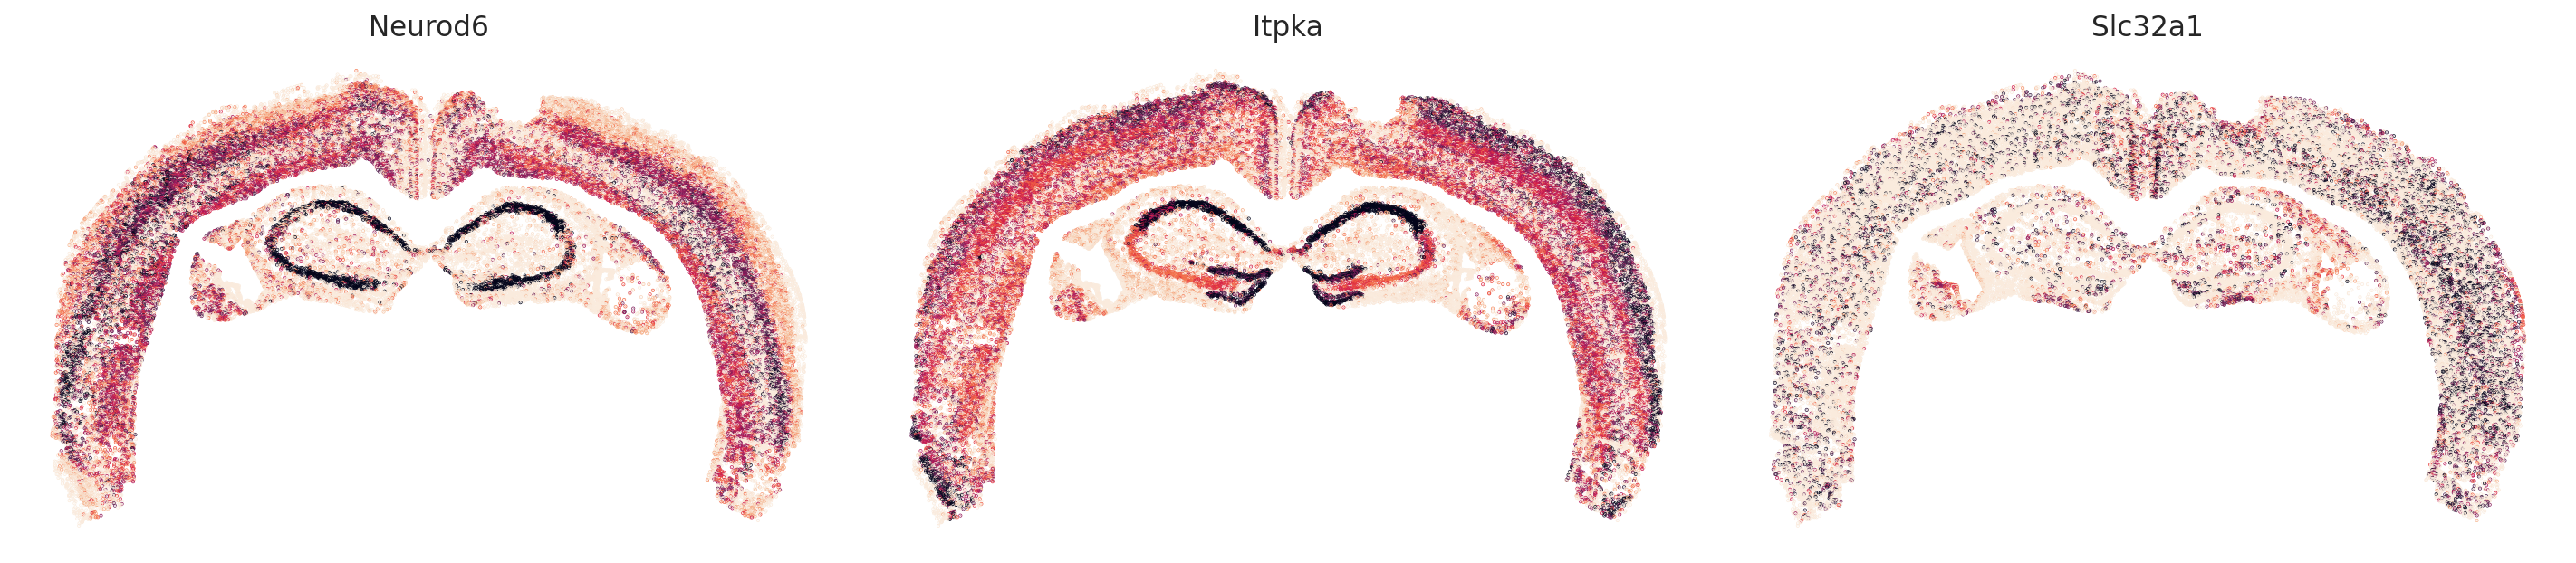

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(6*3,4))
for genei, ax in zip(gene_ids, axs):
    _c = np.power(10, y_pred[:,genei])-1
    lo = np.percentile(_c, 0)
    hi = np.percentile(_c, 95)
    _c = np.clip(_c, lo, hi)

#     data = pd.DataFrame()
#     data['x'] = _x
#     data['y'] = _y
#     data['c'] = _c 
#     scale_paras = {'npxlx': 400}
#     fig, ax = plt.subplots(figsize=(10,8))
#     powerplots.plot_gene_insitu_routine(ax, data, 'x', 'y', 'c', scale_paras, 'rocket_r', 'test')
#     ax.invert_yaxis()
#     plt.show()
    
    ax.scatter(_x, _y, c=_c, s=0.1,
               rasterized=True,
               cmap='rocket_r',
              )
    ax.axis('off')
    ax.invert_yaxis()
    ax.set_aspect('equal')
    ax.set_title(genes[genei])
fig.tight_layout()
powerplots.savefig_autodate(fig, os.path.join(fig_dir, 'dredfish_gene_recon_eg.pdf'))
plt.show()

saved the figure to: /bigstore/GeneralStorage/fangming/projects/dredfish/figures/dredfish_gene_recon_eg_2022-05-12.pdf


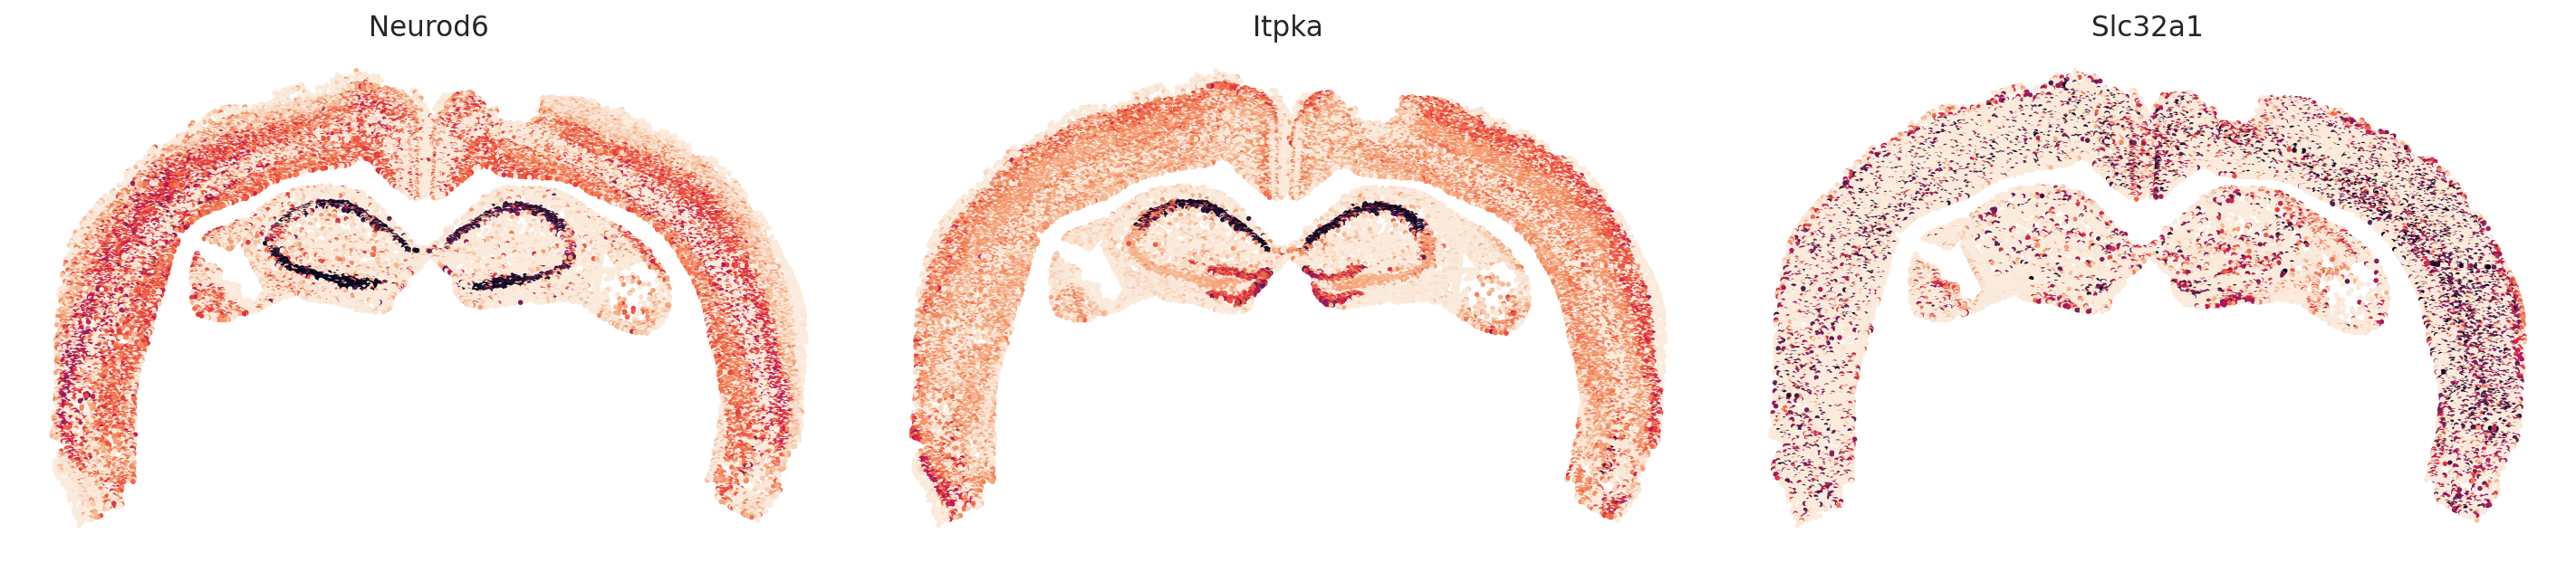

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(6*3,4))
for genei, ax in zip(gene_ids, axs):
    _c = np.power(10, y_pred[:,genei])-1
    lo = np.percentile(_c, 0)
    hi = np.percentile(_c, 99.5)
    _c = np.clip(_c, lo, hi)

    ax.scatter(_x, _y, c=_c, s=0.1,
               rasterized=True,
               cmap='rocket_r',
              )
    ax.axis('off')
    ax.invert_yaxis()
    ax.set_aspect('equal')
    ax.set_title(genes[genei])
fig.tight_layout()
powerplots.savefig_autodate(fig, os.path.join(fig_dir, 'dredfish_gene_recon_eg.pdf'))
plt.show()

saved the figure to: /bigstore/GeneralStorage/fangming/projects/dredfish/figures/dredfish_gene_recon_eg_2022-05-12.pdf


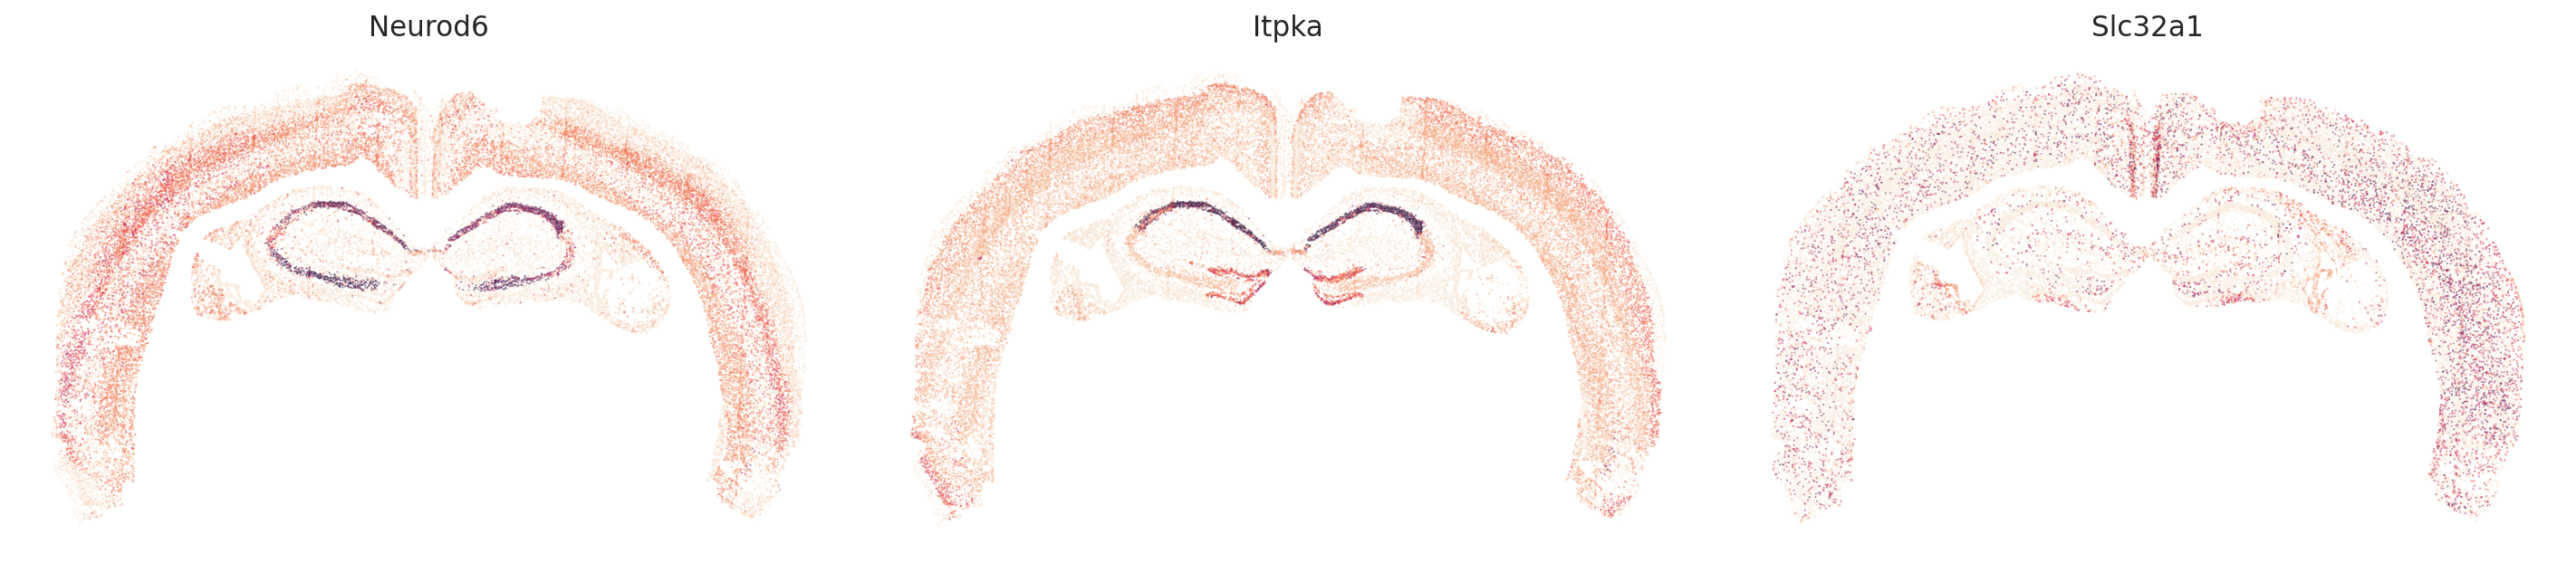

In [40]:
fig, axs = plt.subplots(1, 3, figsize=(6*3,4))
for genei, ax in zip(gene_ids, axs):
    _c = np.power(10, y_pred[:,genei])-1
    lo = np.percentile(_c, 0)
    hi = np.percentile(_c, 100)
    _c = np.clip(_c, lo, hi)

    ax.scatter(_x, _y, c=_c, 
               rasterized=True,
               cmap='rocket_r',
               edgecolor='none',
               s=1, 
               alpha=0.5,
              )
    ax.axis('off')
    ax.invert_yaxis()
    ax.set_aspect('equal')
    ax.set_title(genes[genei])
fig.tight_layout()
powerplots.savefig_autodate(fig, os.path.join(fig_dir, 'dredfish_gene_recon_eg.pdf'))
plt.show()

- Slc32a1 (GABA vesicular transporter)
https://mouse.brain-map.org/experiment/siv?id=72081554&imageId=71974844&initImage=ish&contrast=0.5,0.5,0,255,4

- Stmn3
https://mouse.brain-map.org/experiment/siv?id=1003&imageId=101944049&initImage=ish&contrast=0.5,0.5,0,255,4

- Neurod6 (Hippo CA1 and CA3 - a bit cortex) https://mouse.brain-map.org/experiment/siv?id=698&imageId=101342437&initImage=ish&contrast=0.5,0.5,0,255,4

- Lhx6 https://mouse.brain-map.org/experiment/siv?id=635&imageId=101324452&initImage=ish&contrast=0.5,0.5,0,255,4

- Itpka (Pan-excitatory) https://mouse.brain-map.org/experiment/siv?id=79589520&imageId=79595125&initImage=ish&contrast=0.5,0.5,0,255,4

- Dlx1 https://mouse.brain-map.org/experiment/siv?id=348&imageId=101321278&initImage=ish&contrast=0.5,0.5,0,255,4